In [8]:
%pylab inline
import astropy.units as u
import tmm
from Getindex import load_refraction_data
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)
import TMMSIM
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import astropy.units as u
import os
import pickle
from scipy import interpolate
import bandpass
import imageio

Populating the interactive namespace from numpy and matplotlib


In [11]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

dbfile = open('data/Interpolator.pkl', 'rb')  
interpolator = pickle.load(dbfile)
dbfile.close()

@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,epoxy_um,160, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T

    return(A)

In [265]:
# Wavelength range for each of 6 vibrational bands 
Range = np.array([[923,968],[968,992],[992,1018],[1018,1060],[1060,1100]])

In [69]:
def conv (wlen_min , wlen_max , mask = True, Int_lim = 1):
    
    # define the interested wavelength range interested
    wavelength_mask = (wavelength > wlen_min) & (wavelength < wlen_max)
    yband_range = np.round(wavelength[wavelength_mask],1)
    
    # Calculate convolution for y filter bandpass and sky line
    spec = []
    for i in range(len(yband_range)):
        indx = np.where(yband_wlen == yband_range[i])[0]
        actual = yband_throughput[indx]*intensity[wavelength_mask][i]
        spec.append(actual[0])
        
    spec = np.array(spec)
    # Normalize spectra
    
    
    if mask == True:
        intensity_filter = spec >= Int_lim
        
        line_weight = spec/np.sum(spec)
        return(wavelength_mask,line_weight,intensity_filter,spec)
    else:
        
        line_weight = spec/np.sum(spec)
        return(wavelength_mask,line_weight)

### Simulation at one time

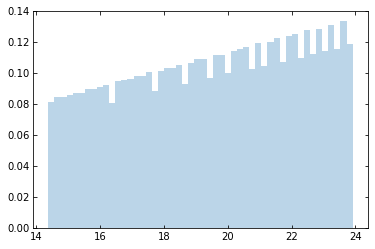

In [29]:
# Incident angle distribution for one pixel on CCD and corresponding weight
angles,weight = bandpass.get_angle(theta_x=0,theta_y=0);

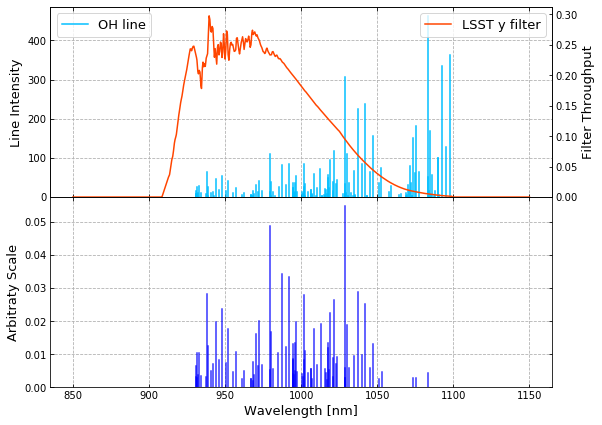

In [7]:
wlenmin = 923
wlenmax = 1100
res = bandpass.conv(wlen_min = wlenmin, wlen_max= wlenmax,Int_lim=1)
line_strength = res[1]
intensity_filter = res[2]
line_weight = line_strength[intensity_filter]/np.sum(line_strength[intensity_filter])
bandpass.plot_conved(res[0],res[1],res[2])

wavelength,intensity = bandpass.sky_line()
wavelengths = np.round(wavelength[res[0]][res[2]],1)

In [23]:
hh = fits.open('data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)

def Fringe_sim2 (inter_func,incident_angle,Weight,thickness):
    z_new = inter_func(thickness,incident_angle)
    z_new = z_new.reshape(len(z_new))
    # Weighted average for the angle range
    count = np.sum(z_new*Weight)

    return(count)

In [52]:
stacked_image_center= np.zeros(shape=(1,4000))
for k in tqdm(range(len(wavelengths))):
    fringing_res3 = np.zeros(shape=(1,4000))
    for i inwa(range(fringing_res3.shape[0])):
        for j in range(fringing_res3.shape[1]):
                fringing_res3[i,j] = Fringe_sim2(inter_func=interpolator[str(wavelengths[k])],
                                                 incident_angle = angles, Weight= weight,thickness = Fitting[i+200,j])
    stacked_image_center += (fringing_res3)*line_weight[k]

100%|██████████| 23/23 [00:02<00:00,  7.99it/s]


### Simulation with OH line temporal variation

In [24]:
# sky line files from 
file = 'data/skyLines.txt'

wavelength = np.loadtxt(file,usecols=[0])
intensity = np.loadtxt(file,usecols=[1])

# LSST y filter throughput
y_filter = 'data/throughputs/baseline/total_y.dat'
yband_wlen = np.round(np.loadtxt(y_filter,usecols=[0]),1)
yband_throughput = np.loadtxt(y_filter,usecols=[1])

# Rel intensity over time from Noll.S et al 2015
boundary = np.array([[304,348],[348,379],[379,434],[434,481],[481,525]])
vib_group = ['8-4','3-0','9-5','4-1','5-2']
eight = [2.26,1.82,1.12,0.67,0.57,0.5,0.614,0.8,0.956,1.065,0.886]
three = [2.825,2.316,1.491,0.768,0.513,0.368,0.373,0.552,0.68,0.768,0.7]
nine = [2.206,1.689,1.114,0.70,0.592,0.539,0.649,0.855,0.987,1.092,0.9]
four = [2.768,2.307,1.434,0.732,0.509,0.4,0.439,0.636,0.763,0.851,0.741]
five = [2.645,2.118,1.329,0.706,0.526,0.43,0.5,0.715,0.868,0.969,0.75]
Time = [0,1,2,3,4,5,6,7,8,9,10]
ac_time = ['7:00 pm','8:00 pm','9:00 pm','10:00 pm','11:00 pm','12:00 am','1:00 am','2:00 am','3:00 am','4:00 am','5:00 am']
Scales = [eight,three,nine,four,five]

Text(0, 0.5, 'Rel. Intensity')

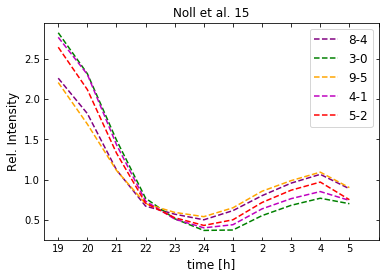

In [26]:
plt.plot(eight,'--',label = '8-4',color = 'purple')
plt.plot(three,'--',label = '3-0', color = 'green')
plt.plot(nine,'--',label = '9-5', color = 'orange')
plt.plot(four,'--',label = '4-1', color = 'm')
plt.plot(five,'--',label = '5-2',color ='red')
plt.legend(loc = 'best',fontsize = 12)

xticks([0,1,2,3,4,5,6,7,8,9,10,11],['19', '20', '21','22','23','24','1','2','3','4','5']);
plt.title('Noll et al. 15',fontsize = 12)
plt.xlabel('time [h]',fontsize = 12)
plt.ylabel('Rel. Intensity',fontsize = 12)

In [21]:
# Code for computing template
groups = {}
# Get weight for each of the 5 vibrational bands
Sum = []
for BAND,scale in zip(boundary,Scales):
    conv_spec = []
    band_range = np.round(wavelength[BAND[0]:BAND[-1]],1)
    intensity_range = intensity[BAND[0]:BAND[-1]]*1
    for i in range(len(band_range)):
        indx = np.where(yband_wlen == band_range[i])[0]
        actual = yband_throughput[indx]*intensity_range[i]
        conv_spec.append(actual[0])
    Sum.append(np.sum(conv_spec))
wgts = Sum/np.sum(Sum)

# Compute template for the 5 bands
ii = 0
for BAND,scale in zip(boundary,Scales):
    
    conv_spec = []
    band_range = np.round(wavelength[BAND[0]:BAND[-1]],1)
    intensity_range = intensity[BAND[0]:BAND[-1]]*1
    for i in range(len(band_range)):
        indx = np.where(yband_wlen == band_range[i])[0]
        actual = yband_throughput[indx]*intensity_range[i]
        conv_spec.append(actual[0])
    line_intensity = np.array(conv_spec/np.sum(conv_spec))
    Sum.append(np.sum(conv_spec))
    
    # Intensity thersohold 
    intensity_filter = line_intensity*wgts[ii] >= 0.002
    
    wavelengths = np.round(wavelength[BAND[0]:BAND[-1]][intensity_filter],1)
    line_weight = line_intensity[intensity_filter]/np.sum(line_intensity[intensity_filter])
    
    stacked_image= np.zeros(shape=(1,4000))
    for k in tqdm(range(len(wavelengths))):
        fringing_res = np.zeros(shape=(1,4000))
        for i in (range(fringing_res.shape[0])):
            for j in range(fringing_res.shape[1]):
                    fringing_res[i,j] = Fringe_sim2(inter_func=interpolator[str(wavelengths[k])],
                                                     incident_angle = angles, Weight= weight,thickness = Fitting[i+200,j])
        stacked_image += (fringing_res)*line_weight[k]
    
    
    groups[vib_group[ii]] = stacked_image[0]
    ii += 1

100%|██████████| 3/3 [00:00<00:00,  8.30it/s]


In [20]:
stack_result = {}
PLOT = False
for q in range(len(Time)):
    time = Time[q]
    # Get weight for each of the 5 vibrational bands
    Sum = []
    for BAND,scale in zip(boundary,Scales):
        conv_spec = []
        band_range = np.round(wavelength[BAND[0]:BAND[-1]],1)
        intensity_range = intensity[BAND[0]:BAND[-1]]*scale[time]
        for i in range(len(band_range)):
            indx = np.where(yband_wlen == band_range[i])[0]
            actual = yband_throughput[indx]*intensity_range[i]
            conv_spec.append(actual[0])
        Sum.append(np.sum(conv_spec))
    wgts = Sum/np.sum(Sum)
    stack_image = np.zeros(shape = 4000)
    for band_weight,vib_trans in zip(wgts,vib_group):
        stack_image += groups[vib_trans]*band_weight
    stack_result[Time[q]] = stack_image
    
    if PLOT == True:
        plt.figure(figsize = (6,4))
        plt.title(str(ac_time[q]),fontsize = 17)
        plt.imshow(stack_image/np.mean(stack_image)-1,vmin = -0.003,vmax = 0.0035)
        plt.colorbar()
        plt.axhline(0,ls = '--',color = 'black')
        plt.ylim(-0.003,0.0035)
        plt.ylabel('Fringing Amplitude',fontsize = 12)
        plt.xlabel('Pixel #',fontsize = 12)
        plt.savefig('data/Paper_plots/aim/Fringe_sim/%i.png'%(q+100))
        plt.close()



In [32]:
kk = 0
for q in range(len(Time)):
    time = Time[q]
    # Get weight for each of the 6 vibrational bands
    Sum = []    
    for BAND,scale in zip(boundary,Scales):
        conv_spec = []
        band_range = np.round(wavelength[BAND[0]:BAND[-1]],1)
        intensity_range = intensity[BAND[0]:BAND[-1]]*scale[time]
        for i in range(len(band_range)):
            indx = np.where(yband_wlen == band_range[i])[0]
            actual = yband_throughput[indx]*intensity_range[i]
            conv_spec.append(actual[0])
        Sum.append(np.sum(conv_spec))
    wgts = Sum/np.sum(Sum)
    color = ['darkorange','c','lawngreen','m','r','g']
    f,axes = plt.subplots(6,figsize = (8,10),sharex = True)
    plt.subplots_adjust(hspace = 0)
    for ax,vib_band,w,c in zip(axes,vib_group,wgts,color):
        ax.plot(groups[vib_band]*w,label = str(vib_band),color = c)
        ax.legend(fontsize = 12,loc = 'lower right')
    axes[-1].plot(stack_result[time],label = 'Stacked',color = 'k')
    axes[-1].legend(fontsize = 12,loc = 'lower right')

    

    ax2 = axes[-1].twinx()
    g = np.mean(stack_result[time])
    #g = (np.max(Sum)+np.min(Sum))/2
    ax2.plot(stack_result[time]/g-1,color = 'k')
    f.text(0.05,0.5,'Absorption Prob x Weight',fontsize = 18,ha = 'center',va = 'center', rotation = 'vertical')
    f.text(1,0.5,'Fringing amplitude',fontsize = 18,ha = 'center',va = 'center', rotation = 'vertical')
    f.savefig('data/Paper_plots/aim/Sep/%i.png'%(kk+100))
    plt.close()
    kk += 1

In [27]:
# Code for plotting OH line plot
for q in range(len(Time)):
    conv_spec = []
    time = Time[q]
    for BAND,scale in zip(boundary,Scales):
        band_range = np.round(wavelength[BAND[0]:BAND[-1]],1)
        intensity_range = intensity[BAND[0]:BAND[-1]]*scale[time]
        for i in range(len(band_range)):
            indx = np.where(yband_wlen == band_range[i])[0]
            actual = yband_throughput[indx]*intensity_range[i]
            conv_spec.append(actual[0])

    colors = ['purple','green','orange','m','red']
    fig, ax1 = plt.subplots(nrows=2, figsize = (9,7),sharex=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    ax1[0].set_title(str(ac_time[q]),fontsize = 17)
    ax2 = ax1[0].twinx()
    for limit,c,scale in zip(boundary,colors,Scales):
        wavelength_range = wavelength[limit[0]:limit[1]]
        for i in range(len(wavelength_range)):
            ax1[0].plot([wavelength_range[i],wavelength_range[i]], [0,intensity[limit[0]:limit[1]][i]*scale[time]], color = c)

    #ax1[0].legend(fontsize = 13,loc = 'upper left')
    ax1[0].grid(ls='--')
    ax1[0].set_ylabel('Line Intensity',fontsize = 13)
    ax1[0].set_ylim(0,1250)

    ax2.plot(yband_wlen[5500:],yband_throughput[5500:],color = 'black',ls = '--',label = 'LSST y filter')
    ax2.legend(fontsize = 13)
    ax2.set_ylim(0,)
    ax2.set_ylabel('Filter Throughput',fontsize= 13)
    #yband_range = np.round(wavelength[wavelength_mask],1)


    norm_spec = conv_spec/np.sum(conv_spec)
    k = 0
    for limit,c in zip(boundary,colors):
        wavelength_range = wavelength[limit[0]:limit[1]]
        for i in range(len(wavelength_range)):
            ax1[1].plot([wavelength_range[i],wavelength_range[i]], [0,norm_spec[k:][i]], color = c)   
        k+= len(wavelength_range)

    ax1[1].set_ylim(0,0.07)
    #ax1[1].set_ylabel('Arbitraty Scale',fontsize = 13)
    ax1[1].grid(ls='--');
    ax1[1].set_xlabel('Wavelength [nm]',fontsize = 13)
    plt.savefig('data/Paper_plots/aim/OH_lines/%i.png'%(q+100))
    plt.close()

In [33]:

files= os.listdir('data/Paper_plots/aim/Sep/')
files.sort()
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
if 'movie.gif' in files:
    files.remove('movie.gif')
if '.DS_Store' in files:
    files.remove('.DS_Store')
    
os.chdir('data/Paper_plots/aim/Sep/')
images = [imageio.imread(file) for file in files]
imageio.mimwrite('movie.gif',images,fps = 6)
os.chdir('../../../..')